$\Large \text{Energetics in Layered Model}$

This notebook contains the code for computing energy conversion terms in energy equations of the mean flow and eddies (derivation is in Barthel et. al 2017, JPO). 

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dask
import dask.distributed
from xgcm import Grid
%matplotlib inline

from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34346 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 406.01 GB


In [17]:
# read prog.nc files for all runs (for 40-50 years simulation time)

tau = ['Tau_001', 'Tau_003', 'Tau_005', 'Tau_01', 'Tau_03', 'Tau_05', 'Tau_1']
ta = ['1.0', '3.0', '5.0', '10.0', '30.0', '50.0', '100.0']

ppdir = "/work/Hemant.Khatri/MOM6_idealised/SWM_Two_Layer/Barotropic_Baroclinic/"

ppdir_tau = "/nbhome/Hemant.Khatri/Topography-Eddy-MOM6/input-files/"

dataset_FW = []
dataset_VW = []

"""
for i in range(0, len(tau)):
    d = xr.open_dataset(ppdir+"2L_fplane_Fix_Width/"+tau[i]+"/prog_avg_50.nc", chunks={'Time': 10}) # specifying chunks is required
    dataset_FW.append(d)
    d = xr.open_dataset(ppdir+"2L_fplane_Var_Width/"+tau[i]+"/prog_avg_50.nc", chunks={'Time': 10}) # for parallel computations
    if(i != 3):
        d = d.drop('taux_bot')
    dataset_VW.append(d)
    
ds_FW1 = xr.concat(dataset_FW, dim='tau')
ds_VW1 = xr.concat(dataset_VW, dim='tau')
"""

ds = xr.open_dataset(ppdir+"2L_fplane_Fix_Width/"+tau[3]+"/prog_avg_50.nc", chunks={'Time': 10})
d = xr.open_dataset(ppdir_tau+"wind_stress_FW_tau_" + ta[3] + ".nc")
ds['taux'] = xr.DataArray(d['taux'].values,dims=['yh','xq'])

ds

/home/Hemant.Khatri/anaconda3/envs/analysis/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


,Array,Chunk
Bytes,934.40 MB,25.60 MB
Shape,"(365, 2, 800, 400)","(10, 2, 800, 400)"
Count,38 Tasks,37 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,934.40 MB,25.60 MB
Shape,"(365, 2, 800, 400)","(10, 2, 800, 400)"
Count,38 Tasks,37 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [18]:
ppdir = "/nbhome/Hemant.Khatri/Topography-Eddy-MOM6/input-files/" 
topo = xr.open_dataset(ppdir+"topography_2L.nc")
ds['depth'] = xr.DataArray(topo['depth'].values,dims=['yh','xh'])

In [19]:
# Grid define for computations 
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X']);
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> right
  * right    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> right
  * right    yq --> center

$\Large \text{Eddy-mean decomposition}$

In [66]:
# Compute meand and eddy components 

# Reynolds Decomposition
um_Rey = ds['u'].mean('Time') 
vm_Rey = ds['v'].mean('Time')
hm_Rey = ds['h'].mean('Time')

ue_Rey = ds['u'] - um_Rey 
ve_Rey = ds['v'] - vm_Rey
he_Rey = ds['h'] - hm_Rey

# Thickness-weighted Decomposition
dx, dy = (4000., 4000.)

hmu = grid.interp(hm_Rey, 'X', boundary='fill') # Interpolate mean on u, v points
hmv = grid.interp(hm_Rey, 'Y', boundary='fill') # use 'fill' to put zeros on boundaries

um_TW = ds['uh'].mean('Time') / (hmu * dy)
vm_TW = ds['vh'].mean('Time') / (hmv * dx)

ue_TW = ds['u'] - um_TW
ve_TW = ds['v'] - vm_TW

# montgomery potentials for eddy and mean flow
H1 = 1000.
g = 9.81
rho = ds['zl'].values[0]
gp = g * (ds['zl'].values[1] -rho)/rho

phi1 =  g * rho * (ds['h'].sum('zl') - ds['depth'])
phi2 = phi1 + gp * rho * (ds['h'].isel(zl=1) - ds['depth'] + H1)

phi = xr.concat([phi1, phi2], ds.zl.values)
phi = phi.drop('zl')
phi = phi.rename({'concat_dim': 'zl'})
phi = phi.transpose('Time','zl','yh','xh')

In [67]:
# Compute mean and eddy kinetic energies

MKE_u = 0.5 * rho * hmu * um_TW * um_TW
MKE_v = 0.5 * rho * hmv * vm_TW * vm_TW

hu = grid.interp(ds['h'], 'X', boundary='fill')
hv = grid.interp(ds['h'], 'Y', boundary='fill')

EKE_u = 0.5 * rho * (hu * ue_TW * ue_TW).mean('Time')
EKE_v = 0.5 * rho * (hv * ve_TW * ve_TW).mean('Time')

$\Large \text{Energy budget terms}$

In [68]:
dx, dy = (4000., 4000.)


# del.(u MKE) and del.(u EKE) terms
tmp1 = - grid.diff(um_TW * MKE_u, 'X', boundary='fill') / dx
tmp2 = - grid.diff(vm_TW * MKE_v, 'Y', boundary='fill') / dy

MKE_bdt1 = tmp1 + tmp2

tmp1 = - grid.diff(um_TW * EKE_u + (ue_TW * EKE_u).mean('Time'), 'X', boundary='fill') / dx
tmp2 = - grid.diff(vm_TW * EKE_v + (ve_TW * EKE_v).mean('Time'), 'Y', boundary='fill') / dy

EKE_bdt1 = tmp1 + tmp2

# Reynolds stress term 

tmp1 = (grid.diff((hu * ue_TW * ue_TW), 'X', boundary='fill') / dx) * (grid.interp(um_TW, 'X', boundary='fill'))

tp = ds['h'] * grid.interp(ue_TW, 'X', boundary='fill') * grid.interp(ve_TW, 'Y', boundary='fill') 
tmp2 = (grid.interp(grid.diff(tp, 'Y', boundary='fill') / dy, 'Y', boundary='fill') *
        grid.interp(um_TW, 'X', boundary='fill'))

tmp3 = (grid.interp(grid.diff(tp, 'X', boundary='fill') / dx, 'X', boundary='fill') *
        grid.interp(vm_TW, 'Y', boundary='fill'))

tmp4 = (grid.diff((hv * ve_TW * ve_TW), 'Y', boundary='fill') / dy) * (grid.interp(vm_TW, 'Y', boundary='fill'))

EKE_bdt3 = rho * (tmp1 + tmp2 + tmp3 + tmp4).mean('Time')

MKE_bdt3 = - EKE_bdt3

# form stress term

phi_m = phi.mean('Time')
phi_e = phi - phi.mean('Time')

tmp1 = hm_Rey * grid.interp( um_TW * grid.diff(phi_m, 'X', boundary='fill') / dx, 'X', boundary='fill')
tmp2 = hm_Rey * grid.interp( vm_TW * grid.diff(phi_m, 'Y', boundary='fill') / dy, 'Y', boundary='fill')
tmp3 = he_Rey * grid.interp( um_TW * grid.diff(phi_e, 'X', boundary='fill') / dx, 'X', boundary='fill')
tmp4 = he_Rey * grid.interp( vm_TW * grid.diff(phi_e, 'Y', boundary='fill') / dy, 'Y', boundary='fill')

MKE_bdt2 = - (tmp1 + tmp2 + tmp3.mean('Time') + tmp4.mean('Time'))

tmp1 = ds['h'] * grid.interp( ue_TW * grid.diff(phi_e, 'X', boundary='fill') / dx, 'X', boundary='fill')
tmp2 = ds['h'] * grid.interp( ve_TW * grid.diff(phi_e, 'Y', boundary='fill') / dy, 'Y', boundary='fill')

EKE_bdt2 = - (tmp1 + tmp2).mean('Time')

# Forcing and friction terms

tmp1 = grid.interp(ds['taux'] * um_TW.isel(zl=0), 'X', boundary='fill')

tmp2 = - (grid.interp(ds['taux_bot'].mean('Time') * um_TW.isel(zl=1), 'X', boundary='fill') + 
        grid.interp(ds['tauy_bot'].mean('Time') * vm_TW.isel(zl=1), 'Y', boundary='fill'))

MKE_bdt4 = xr.concat([tmp1, tmp2], ds.zl.values)
MKE_bdt4 = MKE_bdt4.rename({'concat_dim': 'zl'})
MKE_bdt4 = MKE_bdt4.transpose('zl','yh','xh')

tmp1 = grid.interp(ds['taux'] * ue_TW.isel(zl=0).mean('Time'), 'X', boundary='fill')

tmp2 = - (grid.interp((ds['taux_bot'] * ue_TW.isel(zl=1)).mean('Time'), 'X', boundary='fill') + 
        grid.interp((ds['tauy_bot'] * ve_TW.isel(zl=1)).mean('Time'), 'Y', boundary='fill'))

EKE_bdt4 = xr.concat([tmp1, tmp2], ds.zl.values)
EKE_bdt4 = EKE_bdt4.rename({'concat_dim': 'zl'})
EKE_bdt4 = EKE_bdt4.transpose('zl','yh','xh')

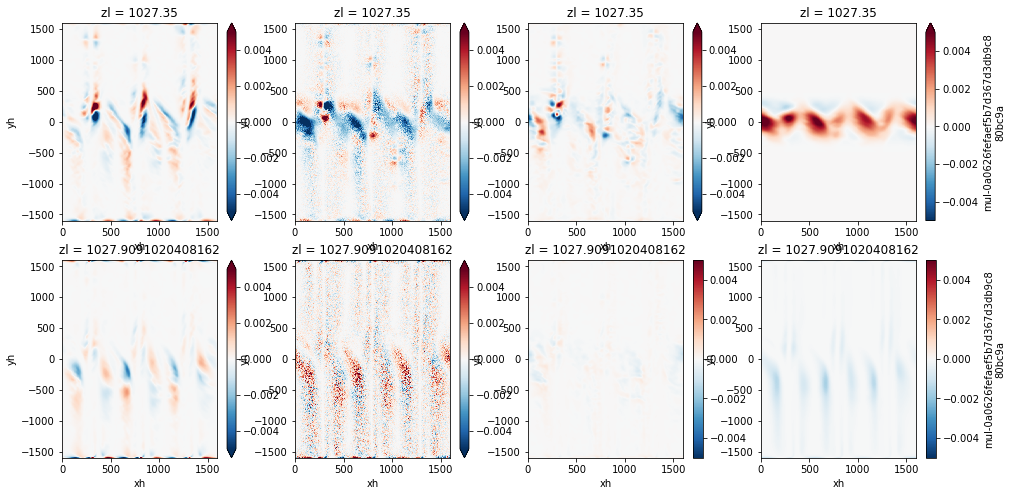

In [69]:
plt.figure(figsize=[16,8])

plt.subplot(2,4,1)
MKE_bdt1.isel(zl=0).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,2)
MKE_bdt2.isel(zl=0).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,3)
MKE_bdt3.isel(zl=0).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,4)
MKE_bdt4.isel(zl=0).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,5)
MKE_bdt1.isel(zl=1).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,6)
MKE_bdt2.isel(zl=1).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,7)
MKE_bdt3.isel(zl=1).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,8)
MKE_bdt4.isel(zl=1).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

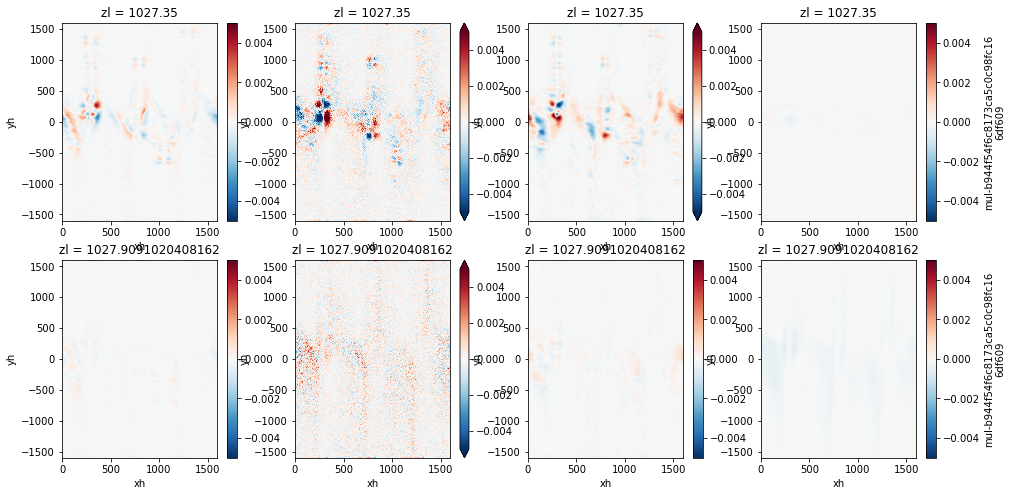

In [70]:
plt.figure(figsize=[16,8])

plt.subplot(2,4,1)
EKE_bdt1.isel(zl=0).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,2)
EKE_bdt2.isel(zl=0).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,3)
EKE_bdt3.isel(zl=0).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,4)
EKE_bdt4.isel(zl=0).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,5)
EKE_bdt1.isel(zl=1).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,6)
EKE_bdt2.isel(zl=1).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,7)
EKE_bdt3.isel(zl=1).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

plt.subplot(2,4,8)
EKE_bdt4.isel(zl=1).plot(vmin=-0.005, vmax = 0.005, cmap = 'RdBu_r')

In [71]:
# Domain mean energy terms

print('MKE_bdt1 = ', MKE_bdt1.mean(['xh','yh']).values)
print('MKE_bdt2 = ', MKE_bdt2.mean(['xh','yh']).values)
print('MKE_bdt3 = ', MKE_bdt3.mean(['xh','yh']).values)
print('MKE_bdt4 = ', MKE_bdt4.mean(['xh','yh']).values)
print(" ")
print('EKE_bdt1 = ', EKE_bdt1.mean(['xh','yh']).values)
print('EKE_bdt2 = ', EKE_bdt2.mean(['xh','yh']).values)
print('EKE_bdt3 = ', EKE_bdt3.mean(['xh','yh']).values)
print('EKE_bdt4 = ', EKE_bdt4.mean(['xh','yh']).values)

MKE_bdt1 =  [-2.6666247e-10 -2.6120014e-10]
MKE_bdt2 =  [-0.00020816  0.00011492]
MKE_bdt3 =  [-1.7162751e-05  3.8374145e-07]
MKE_bdt4 =  [ 0.00024385 -0.00012844]
 
EKE_bdt1 =  [-1.1716714e-10 -1.1390052e-09]
EKE_bdt2 =  [2.03045416e-05 7.89272677e-05]
EKE_bdt3 =  [ 1.7162751e-05 -3.8374145e-07]
EKE_bdt4 =  [ 1.20781025e-06 -7.37435076e-05]


In [50]:
# Domain mean energy terms

print('MKE_bdt1 = ', MKE_bdt1.mean(['xh','yh']).values)
print('MKE_bdt2 = ', MKE_bdt2.mean(['xh','yh']).values)
print('MKE_bdt3 = ', MKE_bdt3.mean(['xh','yh']).values)
print('MKE_bdt4 = ', MKE_bdt4.mean(['xh','yh']).values)
print(" ")
print('EKE_bdt1 = ', EKE_bdt1.mean(['xh','yh']).values)
print('EKE_bdt2 = ', EKE_bdt2.mean(['xh','yh']).values)
print('EKE_bdt3 = ', EKE_bdt3.mean(['xh','yh']).values)
print('EKE_bdt4 = ', EKE_bdt4.mean(['xh','yh']).values)

MKE_bdt1 =  [-2.6666247e-10 -2.6120014e-10]
MKE_bdt2 =  [-0.00020816  0.00016372]
MKE_bdt3 =  [-1.7162751e-05  3.8374145e-07]
MKE_bdt4 =  [ 0.00024385 -0.00012844]
 
EKE_bdt1 =  [-1.1716714e-10 -1.1390052e-09]
EKE_bdt2 =  [2.03045416e-05 1.21998534e-04]
EKE_bdt3 =  [ 1.7162751e-05 -3.8374145e-07]
EKE_bdt4 =  [ 1.20781025e-06 -7.37435076e-05]


In [73]:
tmp1 = MKE_bdt1.mean().values + MKE_bdt2.mean().values + MKE_bdt3.mean().values + MKE_bdt4.mean().values
tmp2 = EKE_bdt1.mean().values + EKE_bdt2.mean().values + EKE_bdt3.mean().values + EKE_bdt4.mean().values

print("Overall Balance = ", tmp1 + tmp2)

Overall Balance =  2.4572638468221585e-05


In [74]:
print("MKE = ", tmp1,", EKE = ", tmp2)

MKE =  2.8122705529479036e-06 , EKE =  2.176036791527368e-05


$\Large \text{Other checks}$

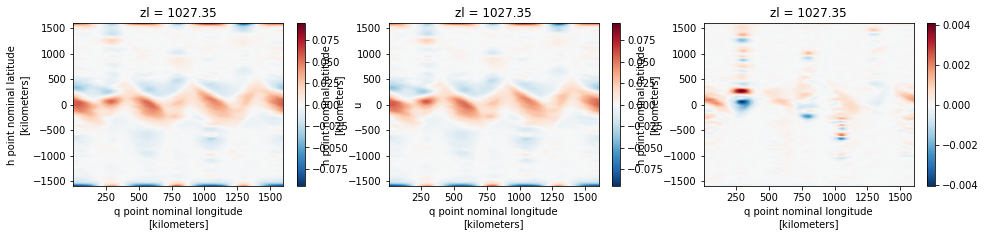

In [13]:
plt.figure(figsize=[16,3])

plt.subplot(1,3,1)
um_Rey.isel(zl=0).plot()

plt.subplot(1,3,2)
um_TW.isel(zl=0).plot()

plt.subplot(1,3,3)
(um_Rey - um_TW).isel(zl=0).plot()

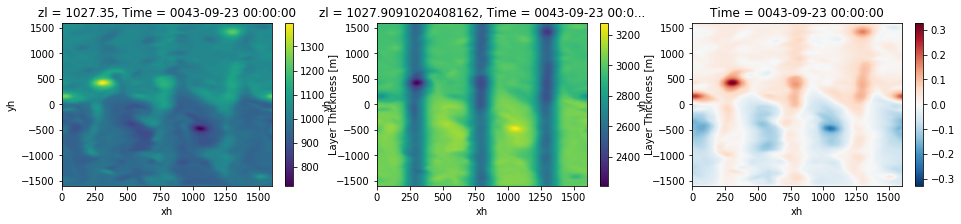

In [18]:
plt.figure(figsize=[16,3])

plt.subplot(1,3,1)
#hm_Rey.isel(zl=0).plot()
ds['h'].isel(zl=0,Time=100).plot()

plt.subplot(1,3,2)
#hm_Rey.isel(zl=1).plot()
ds['h'].isel(zl=1,Time=100).plot()

plt.subplot(1,3,3)
#hm_Rey.sum('zl').plot()
(ds['h'].isel(Time=100).sum('zl') - ds['depth']).plot()

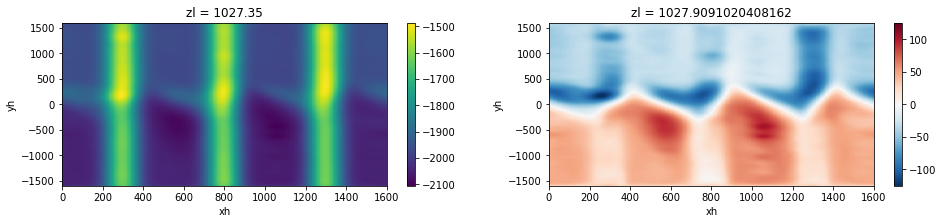

In [65]:
plt.figure(figsize=[16,3])

plt.subplot(1,2,1)
t1 = (ds['h'].isel(zl=0).mean('Time') - ds['depth'] + H1)
t1.plot()

plt.subplot(1,2,2)
t2 = (ds['h'].isel(zl=1).mean('Time') - ds['depth'] + H1)
t2.plot()

In [20]:
g = 9.81
rho = ds['zl'].values[0]
gp = g * (ds['zl'].values[1] -rho)/rho

gp

0.005338775510203277

In [75]:
ds.close()
client.close()
cluster.close()